# Introduction to mvSuSiE for multi-trait fine-mapping

author: Yuxin Zou, Gao Wang, Peter Carbonetto and Matthew Stephens

Originally posted on [mvsusieR vignette](https://stephenslab.github.io/mvsusieR/articles/mvsusie_intro.html)

The aim of this vignette is to work through the steps of a basic
mvSuSiE multi-trait fine-mapping analysis. We analyze a simulated
fine-mapping data set with realistic genotypes.

First, load the necessary packages, and to ensure reproducibility set
the seed.

In [1]:
library(mvsusieR)
library(ggplot2)
library(cowplot)
set.seed(1)

Loading required package: mashr

Loading required package: ashr

Loading required package: susieR



Next, load the data set we will analyze.

In [2]:
data(simdata)

The data consist of an $N \times J$ genotype matrix `X` and an $N
\times R$ phenotype matrix `Y` where $N$ is the number of samples, $J$
is the number of SNPs, and $R$ is the number of traits/phenotypes.

In [3]:
X <- simdata$raw$X
Y <- simdata$raw$Y
dim(X)
dim(Y)

[1]  574 1001

[1] 574  20

Specify the prior
-----------------

Some care should be taken to choose the prior for your mvSuSiE
analysis. To simplify the example we have defined the prior for you:

In [4]:
prior <- create_mixture_prior(list(matrices = simdata$par$U,
                                   weights = simdata$par$w),
                              null_weight = 0)

More generally, we recommend taking a "data-driven" approach to
estimating the weights and the covariance matrices in the prior. For
example, when there are many candidate fine-mapping regions in your
study, you could fit the prior to all the top associations from each
of the candidate fine-mapping regions. This data-driven approach is
quite similar to the approach used in [mashr][mashr], and we recommend
looking through the vignettes in the mashr package for further guidance.

Fit the mvSuSiE model
---------------------

Now that we have set up the prior, we are ready to run mvsusie:

In [5]:
fit <- mvsusie(X,Y,standardize = TRUE,
               prior_variance = prior,
               residual_variance = simdata$par$V,
			   estimate_prior_variance = TRUE,
			   tol = 0.01)

Initializing data object...

Dimension of X matrix: 574 1001

Dimension of Y matrix: 574 20

Initializing prior object ...

Number of components in the mixture prior: 20

Running IBSS algorithm...

Iteration 1 delta = Inf

Iteration 2 delta = 31.0117608064538

Iteration 3 delta = 1.45487855527244

Iteration 4 delta = 0.676754236550551

Iteration 5 delta = 0.432714648311958

Iteration 6 delta = 0.308027641538501

Iteration 7 delta = 0.234364249556165

Iteration 8 delta = 0.186389430893541

Iteration 9 delta = 0.152773426969361

Iteration 10 delta = 0.127958230748845

Iteration 11 delta = 0.190949569803706

Iteration 12 delta = 0.438205737900716

Iteration 13 delta = 0.016458652818983

Iteration 14 delta = 0.0155586413329729

Iteration 15 delta = 0.0147936737139389

Iteration 16 delta = 0.0138843746390194

Iteration 17 delta = 0.0126234407434822

Iteration 18 delta = 0.0109375095944415

Iteration 19 delta = 0.00896087709406856



In this call, we have provided mvSuSiE with the four key pieces of
information need to run the analysis: (1) the genotype matrix; (2) the
phenotype matrix, (3) the prior on the effects; and (4) the residual
variance-covariance matrix (an $R \times R$ matrix).

The "tol" parameter tells the IBSS model fitting algorithm when to stop
iterating; for a final analysis, you may want to set a more stringent
tolerance (a number closer to zero).

Identifying the causal SNPs: Credible Sets 
------------------------------------------

By default, the "mvsusie" function fits a model with L = 10 single
effects. mvSuSiE is generally robust to misspecification of L so long
as L is chosen to be larger than the true number of effects. mvSuSiE
prunes unneeded single effects by estimating a scaling coefficient in
the prior; we set `estimate_prior_variance = TRUE` to turn on this
pruning step. Indeed, mvsusie pruned 7 out of 10 of the single effects,
resulting in three 95% credible sets (CSs), each of which contain
exactly one of the true causal SNPs:

In [6]:
fit$sets$cs

$L1
[1] 335

$L2
[1] 255

$L3
[1] 481 484 493 494 499 508 509 512

In the third CS, mvSuSiE cannot decide which SNP is the causal SNP
because the candidate SNPs are strongly correlated with each other:

In [7]:
fit$sets$purity

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1.0000000
L2,1.0000000,1.0000000,1.0000000
L3,0.9559005,0.9803777,0.9801855


Examining the posterior inclusion probabilties (PIPs) for these SNPs,
there is a subset of 3 SNPs that account for >58% of probability for
being causal:

In [8]:
markers <- fit$sets$cs$L3
fit$pip[markers]

v481       v484       v493       v494       v499       v508       v509 
0.02205462 0.16625677 0.39305212 0.16937313 0.02670885 0.04688452 0.07230198 
      v512 
0.07009722

Additionally, the "sentinel" SNP---the SNP with the highest PIP---as a
PIP of nearly 40%.

This is all summarized visually in a "PIP plot":

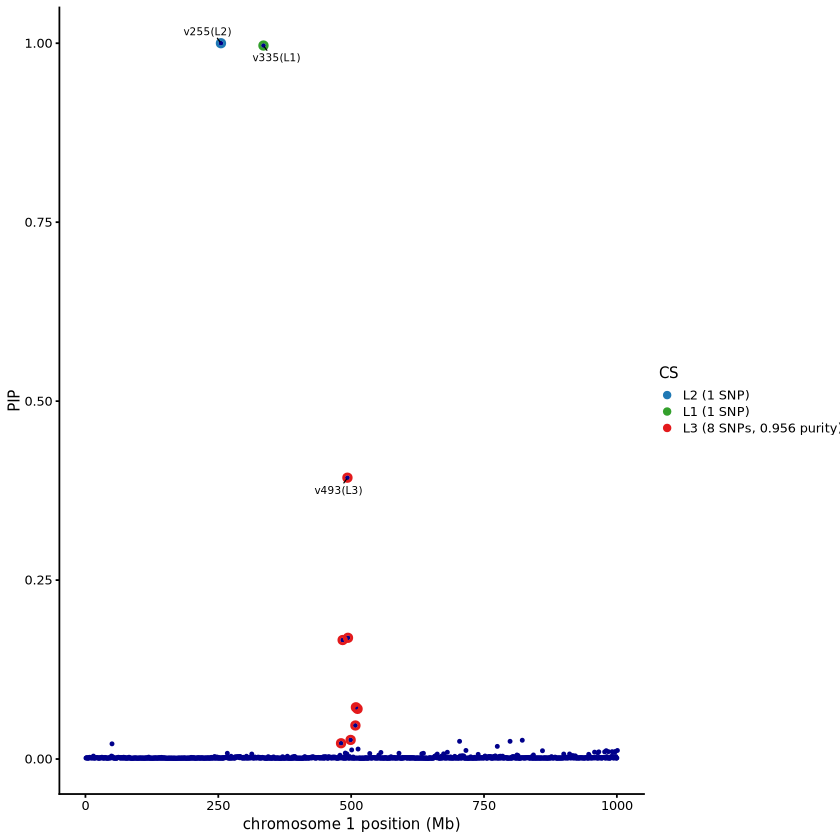

In [9]:
mvsusie_plot(fit)$pip_plot

Determining which traits are affected
-------------------------------------

In a multi-trait analysis, we are not just interested in identifying
the causal SNPs, but also _which traits_ are affected by these causal
SNPs.

Let's take the first CS as an example. This is an example of a causal
SNP that affects most traits:

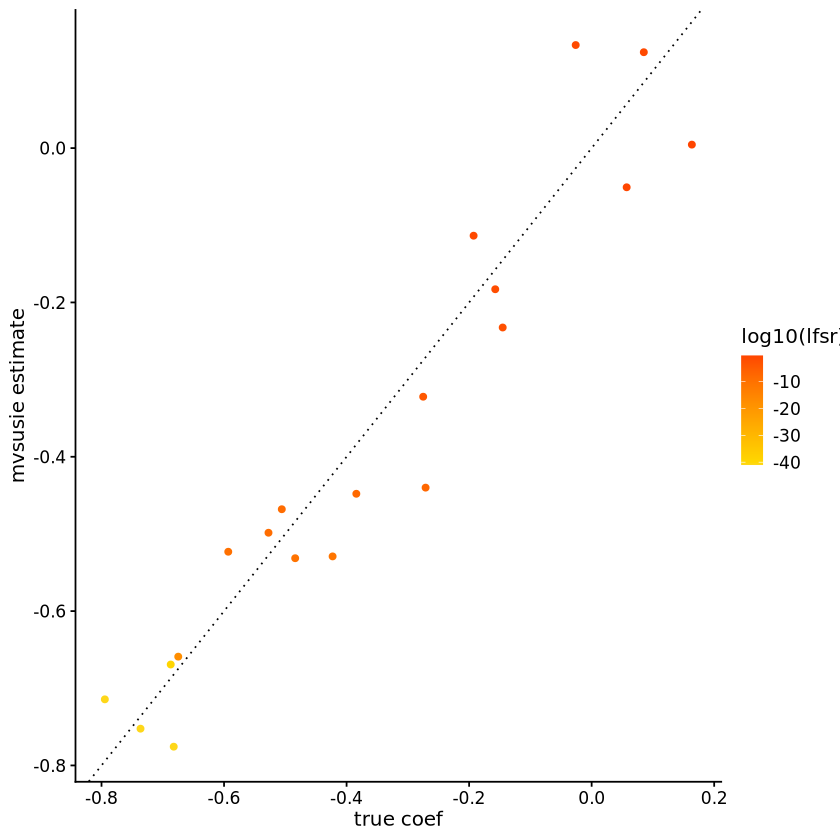

In [10]:
l <- 1
i <- 335
pdat <- data.frame(bhat = simdata$Btrue[i,],
                   coef = fit$b1_rescaled[l,i+1,],
                   lfsr = fit$single_effect_lfsr[l,])
ggplot(pdat,aes(x = bhat,y = coef,color = log10(lfsr),pch = 20)) +
  geom_point(shape = 20,size = 2.5) +
  geom_abline(intercept = 0,slope = 1,color = "black",linetype = "dotted") +
  scale_color_gradient2(low = "lightskyblue",mid = "gold",high = "orangered",
                        midpoint = -40) +
  labs(x = "true coef",y = "mvsusie estimate") +
  theme_cowplot(font_size = 12)

Indeed, the effects of this causal SNP are significant---*i.e.,* small
local false sign rates---for most of the 20 traits. (A local false
sign rate can be thought of as an alternative to a *p*-value, but is
typically slightly more conservative than a *p*-value.)

Also, it is reassuring that the mvsusie estimates of the coefficients
align well with the coefficients used to simulate the data.

By contrast, the causal SNP identified by the third CS only affects
one trait, and the affected trait was correctly identified by mvsusie:

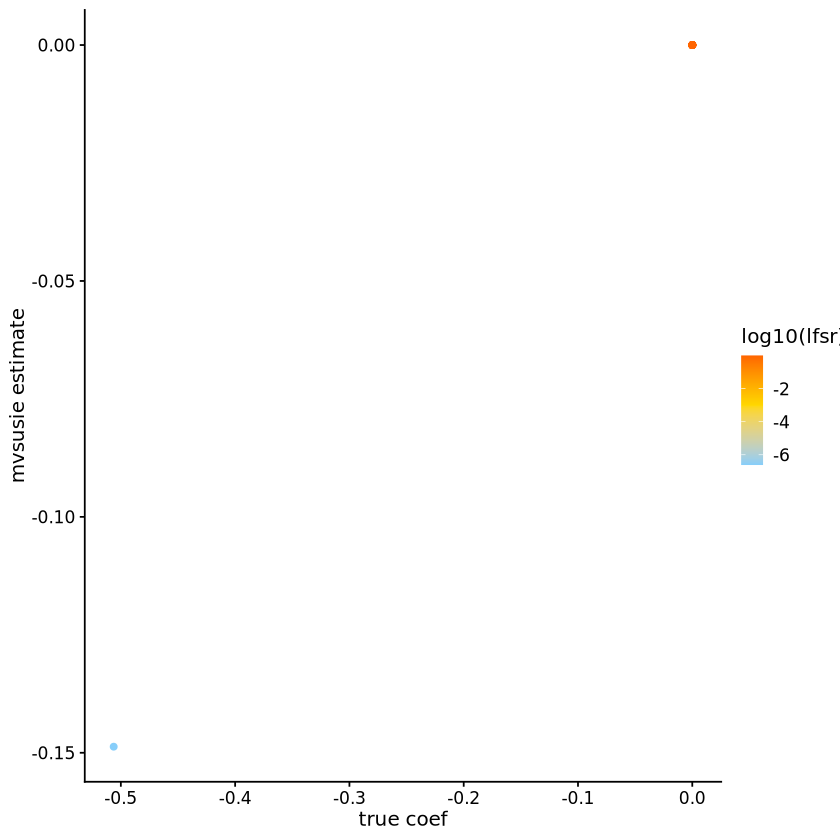

In [11]:
l <- 3
i <- 493
pdat <- data.frame(bhat = simdata$Btrue[i,],
                   coef = fit$b1_rescaled[l,i+1,],
                   lfsr = fit$single_effect_lfsr[l,])
ggplot(pdat,aes(x = bhat,y = coef,color = log10(lfsr),pch = 20)) +
  geom_point(shape = 20,size = 2.5) +
  scale_color_gradient2(low = "lightskyblue",mid = "gold",high = "orangered",
                        midpoint = -3) +
  labs(x = "true coef",y = "mvsusie estimate") +
  theme_cowplot(font_size = 12)

Notice that the lfsr is very small for the first trait (<1e-6) whereas
the lfsrs for the rest of the traits are all close to 1.

The information about which traits are affected by the causal SNP is
summarized in the "effect plot":

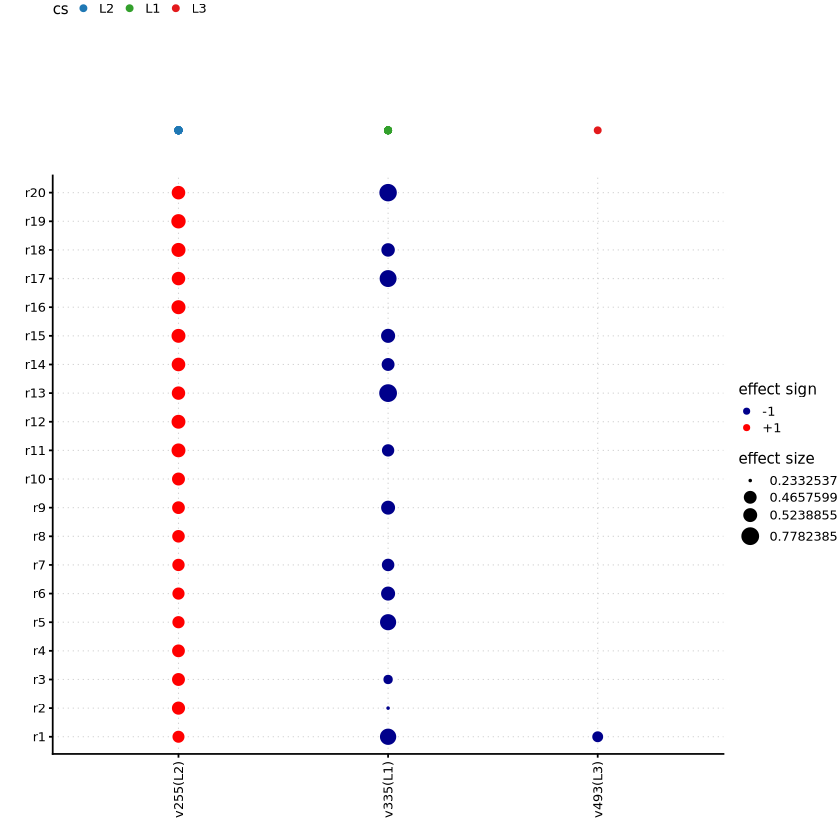

In [12]:
out <- mvsusie_plot(fit,add_cs = TRUE)
out$effect_plot

mvSuSiE with summary data: mvSuSiE-RSS
--------------------------------------

mvsusieR also provides a "summary data" interface, building on the
ideas developed in the [susie-rss paper][susie-rss]. Different
combinations of summary statistics are accepted, but here we will
focus on the most common case in which the *z*-scores from the
association tests are used. These *z*-scores should be stored in a $J
\times R$ matrix:

In [13]:
Z <- simdata$sumstats$z
dim(Z)

[1] 1001   20

In addition to the *z*-scores, the sample size and $R \times R$ LD
(correlation) matrix are needed. (Strictly speaking, the sample size
is not required, but the estimates may be less accurate if the sample
size is not provided.)

In [14]:
n <- simdata$sumstats$n
R <- simdata$sumstats$LD

Now we can fit an mvSuSiE model to these summary data via the
`mvsusie_rss` interface:

In [15]:
fit_rss <- mvsusie_rss(Z,R,n,
                       prior_variance = prior,
					   residual_variance = simdata$par$V,
					   estimate_prior_variance = TRUE,
					   tol = 0.01)

Initializing prior object ...

Number of components in the mixture prior: 20

Running IBSS algorithm...

Iteration 1 delta = Inf

Iteration 2 delta = 31.0117608064538

Iteration 3 delta = 1.45487855527062

Iteration 4 delta = 0.67675423655237

Iteration 5 delta = 0.432714648311958

Iteration 6 delta = 0.308027641536682

Iteration 7 delta = 0.234364249556165

Iteration 8 delta = 0.18638943089536

Iteration 9 delta = 0.152773426969361

Iteration 10 delta = 0.127958230748845

Iteration 11 delta = 0.190949569801887

Iteration 12 delta = 0.438205737900716

Iteration 13 delta = 0.0164586528208019

Iteration 14 delta = 0.0155586413311539

Iteration 15 delta = 0.0147936737139389

Iteration 16 delta = 0.0138843746390194

Iteration 17 delta = 0.0126234407453012

Iteration 18 delta = 0.0109375095926225

Iteration 19 delta = 0.00896087709406856



The call to `mvsusie_rss` is very similar to the call to `mvsusie`
above, except that the individual-level data are replaced with summary
data.

When the genotypes are standardized in `mvsusie` (`standardize =
TRUE`) and the LD estimates are obtained from the same data that were
used to compute the *z*-scores, both `mvsusie` and `mvsusie_rss`
should give the same result:

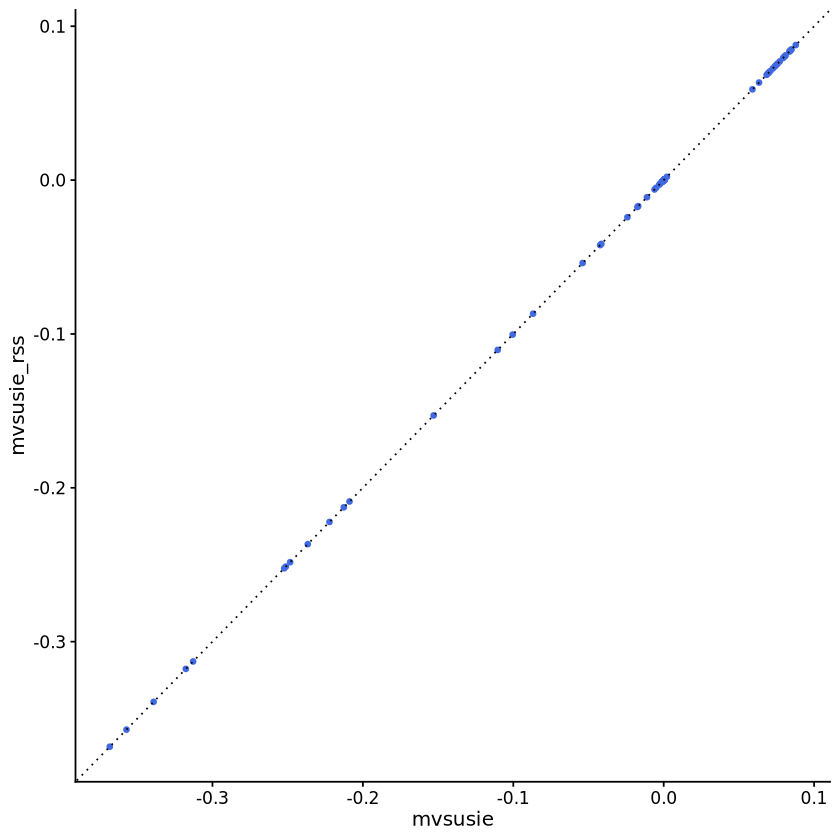

In [16]:
pdat <- data.frame(b1     = as.vector(fit$b1),
                   b1_rss = as.vector(fit_rss$b1))
ggplot(pdat,aes(x = b1,y = b1_rss)) +
  geom_point(shape = 20,size = 2,color = "royalblue") +
  geom_abline(intercept = 0,slope = 1,color = "black",linetype = "dotted") +
  labs(x = "mvsusie",y = "mvsusie_rss") +
  theme_cowplot(font_size = 12)

Of course, the result is not always expected to be the same---for
example, when the LD is estimated from an external reference panel.

Estimating the residual variance
--------------------------------

In the above examples, we set the residual variance to the value that
was used to simulated the data. In practice of course we will not have
access to this so we will have to estimate the residual variance somehow.

When one has access to the summary data (specifically, the z-scores)
for a large pool of independent SNPs that are expected to have little
to no effect on the traits, one can use these z-scores to estimate the
residual variance. Here, in this example data set, we do not have
access to a large pool of independent "null SNPs", but we can still
use the data we have available to obtain a rough estimate of the
residual variance.  Specifically, we take as the "null SNPs" the SNPs
in which the z-scores are all less than 2 in magnitude:

In [17]:
Z <- simdata$sumstats$z
null_markers <- which(apply(abs(Z),1,max) < 2)
length(null_markers)
Z <- Z[null_markers,]
Vest <- cov(Z)

[1] 291

The estimate of the residual covariance matrix using these SNPs is
reasonable, although presumably one could do better if we had the
z-scores for more SNPs that were not in LD with the causal SNPs:

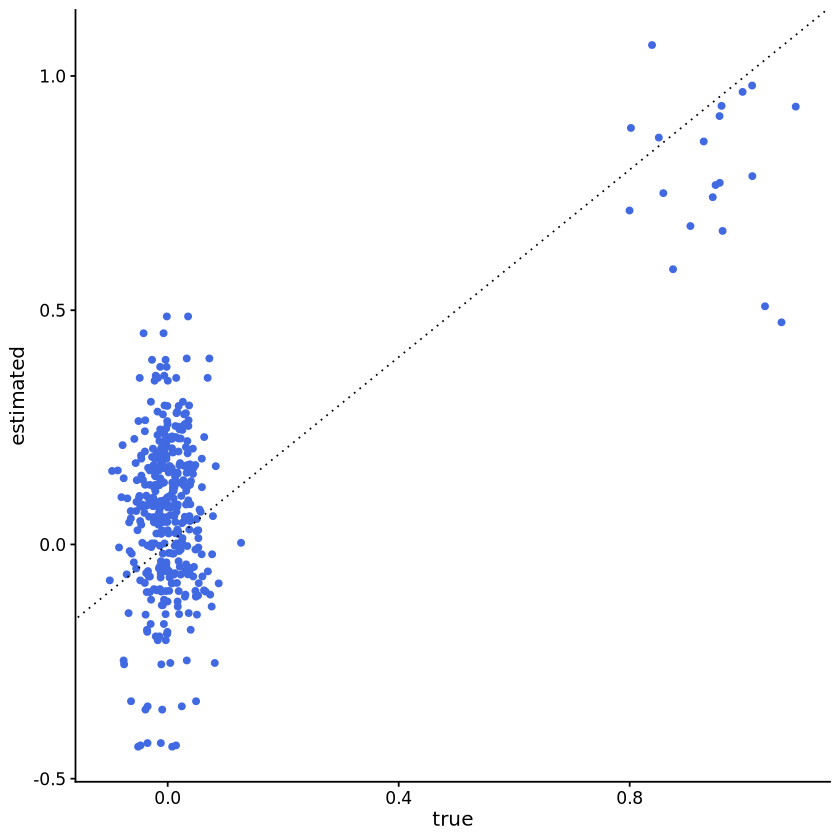

In [18]:
pdat <- data.frame(true = as.vector(simdata$par$V) + rnorm(400)/30,
                   estimated = as.vector(Vest))
ggplot(pdat,aes(x = true,y = estimated)) +
  geom_point(shape = 20,size = 2.5,color = "royalblue") +
  geom_abline(intercept = 0,slope = 1,color = "black",linetype = "dotted") +
  theme_cowplot(font_size = 12)

[mashr]: https://github.com/stephenslab/mashr
[susie-rss]: https://doi.org/10.1371/journal.pgen.1010299